In [ ]:
# adapted from https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb
import spacy
import nltk
import pandas as pd
import numpy as np
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from pylab import rcParams

from nltk.corpus import gutenberg
# import Emma by Jane Austin
emma_raw = gutenberg.raw("austen-emma.txt")


In [2]:
emma_raw

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.\n\nShe was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister\'s marriage,\nbeen mistress of his house from a very early period.  Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.\n\nSixteen years had Miss Taylor been in Mr. Woodhouse\'s family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.  Between _them_ it was more the intimacy\nof sisters.  Even before Miss Taylor had ceased to hold the nominal\noffice o

In [3]:
nlp = spacy.load('en')

In [4]:
emma = nlp(emma_raw)

In [5]:
emma[:10]

[Emma by Jane Austen 1816]

VOLUME I

In [ ]:
# Exploring the document

In [8]:
# Create a generator
next(emma.sents)

[Emma by Jane Austen 1816]

VOLUME

In [9]:
emmaSents = list(emma.sents)

In [11]:
emmaSents[-5:]

[While either of them protected him and his, Hartfield was safe.--,
 But Mr. John Knightley must be in London again by the end of the
 first week in November.
 ,
 The result of this distress was, that, with a much more voluntary,
 cheerful consent than his daughter had ever presumed to hope for at
 the moment, she was able to fix her wedding-day--and Mr. Elton was
 called on, within a month from the marriage of Mr. and Mrs. Robert
 Martin, to join the hands of Mr. Knightley and Miss Woodhouse.
 ,
 The wedding was very much like other weddings, where the parties
 have no taste for finery or parade; and Mrs. Elton, from the
 particulars detailed by her husband, thought it all extremely shabby,
 and very inferior to her own.--"Very little white satin, very few
 lace veils; a most pitiful business!--Selina would stare when she
 heard of it."--But, in spite of these deficiencies, the wishes,
 the hopes, the confidence, the predictions of the small band
 of true friends who witnessed the cer

In [13]:
# Find the longest sentences
emmaSentenceLengths = [len(sent) for sent in emmaSents]
[sent for sent in emmaSents if len(sent) == max(emmaSentenceLengths)]

[Had she followed Mr. Knightley's known wishes, in paying
 that attention to Miss Fairfax, which was every way her due; had she
 tried to know her better; had she done her part towards intimacy;
 had she endeavoured to find a friend there instead of in Harriet Smith;
 she must, in all probability, have been spared from every pain
 which pressed on her now.--Birth, abilities, and education,
 had been equally marking one as an associate for her, to be received
 with gratitude; and the other--what was she?--Supposing even that
 they had never become intimate friends; that she had never been
 admitted into Miss Fairfax's confidence on this important matter--
 which was most probable--still, in knowing her as she ought,
 and as she might, she must have been preserved from the abominable
 suspicions of an improper attachment to Mr. Dixon, which she had
 not only so foolishly fashioned and harboured herself, but had so
 unpardonably imparted; an idea which she greatly feared had been made
 a 

In [25]:
# Show properties available for each word
print(emma[19])
[prop for prop in dir(emma[19]) if not prop.startswith('_')]

clever


['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'shape',
 'shape_',
 'similarity',
 'string',
 'subtree',
 'suffix',
 'suffix_',
 'tag',
 'tag_',
 'text',
 'text_wi

In [26]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram(
        [word.i for word in haystack 
         if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfca1595f8>,
      dtype=object)

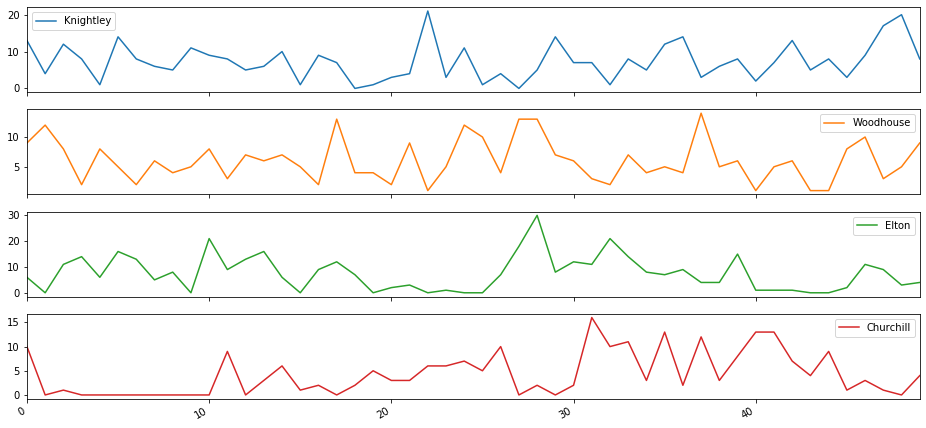

In [30]:
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), emma) 
     for name in ['Knightley', 'Woodhouse', 'Elton', 'Churchill']}
).plot(subplots=True)

# Exploring Named Entities
Named entities can be accessed through doc.ents. Let's find all the types of named entities

In [33]:
set([w.label_ for w in emma.ents])

{'CARDINAL',
 'DATE',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [34]:
# Place Names
[ent for ent in emma.ents if ent.label_ == 'GPE']

[London,
 Hartfield,
 Hartfield,
 Hartfield,
 Highbury,
 London,
 Emma Woodhouse,
 Broadway Lane,
 Highbury,
 Highbury,
 London,
 Highbury,
 Highbury,
 London,
 Highbury,
 Highbury,
 Highbury,
 Randalls,
 Hartfield,
 Randalls,
 Highbury,
 Hartfield,
 Highbury,
 Hartfield,
 Highbury,
 Hartfield,
 Highbury,
 Donwell,
 Highbury,
 Hartfield,
 Vicar,
 Wakefield,
 Highbury,
 Kingston,
 Hartfield,
 Hartfield,
 Hartfield,
 Highbury,
 Hartfield,
 Highbury,
 Hartfield,
 Weston,
 Emma,
 Hartfield,
 Hartfield,
 Hartfield,
 Randalls,
 London,
 London,
 London,
 London,
 Hartfield,
 Abbey-Mill,
 Hartfield,
 Hartfield,
 Hartfield,
 Hartfield,
 Highbury,
 Randalls,
 London,
 Hartfield,
 Hartfield,
 Hartfield,
 Hartfield,
 Michaelmas,
 Highbury,
 Hartfield,
 Hartfield,
 Hartfield,
 Harriet,
 Highbury,
 Highbury,
 Hartfield,
 Highbury,
 Hartfield,
 Wiltshire,
 Hartfield,
 London,
 Hartfield,
 Randalls,
 Randalls,
 part.--,
 Cobham,
 Weymouth,
 Hartfield,
 Donwell,
 London,
 London,
 London,
 London,
 Ha

In [36]:
set(list([ent.string.strip() for ent in emma.ents if ent.label_ == 'PERSON']))

{'A. W.',
 'Abbey',
 'Abbey!--Oh',
 'Absolute',
 'Aladdin',
 'Alas',
 'Alderneys',
 'Altogether',
 'Angry',
 'Anna Weston',
 'Anne Cox',
 'Arthur!--How',
 'Astley',
 'Augusta',
 'Augusta Hawkins',
 'Aunt Emma',
 'Aye',
 'Baly',
 'Barnes',
 'Bates',
 'Bates?--I',
 'Bateses',
 'Behold',
 'Bella',
 'Bickerton',
 'Bird',
 'Box Hill',
 'Bragge',
 'Bragges',
 'Bristol',
 'Broadwood',
 "Brown's",
 'Brunswick Square.--Isabella',
 'Brunswick Square;--and',
 'Campbell',
 'Campbells',
 'Captain Weston',
 'Catherine',
 'Churchill',
 'Churchill--',
 'Churchills',
 'Clara Partridge',
 'Cole',
 'Cole--',
 'Coles',
 'Come Emma',
 'Cowper',
 'Cox',
 'Crown',
 'Dear Jane',
 'Decidedly',
 'Depend',
 'Dinner',
 'Dixon',
 'Dixons',
 'Donwell',
 'Donwell Abbey',
 'Donwell Lane',
 'Donwell?--He',
 'E.',
 'Easter',
 'Elizabeth',
 'Elizabeth Martin',
 "Elizabeth Martin's",
 'Elton',
 'Elton!--',
 'Elton!--`Jane Fairfax',
 'Elton!--no',
 "Elton's",
 'Elton--',
 'Elton.--',
 'Elton?--',
 'Eltons',
 'Emma',
 'Emm

In [37]:
set([ent.string for ent in emma.ents if ent.label_ == 'NORP'])

{'Adelaide ',
 'Campbells ',
 'Chili ',
 'Christian ',
 'English ',
 'French',
 'Harriet',
 'Harriet ',
 'Highbury ',
 'Irish ',
 'Italian ',
 'Knightley!--Mr',
 'Milmans',
 'Pembroke',
 'Perrys',
 'Tupmans',
 'can;--to ',
 'correct.--I ',
 'effect.--I ',
 'herself.--In ',
 'persuadable.--'}

In [38]:
# Make a quick-and-dirty lookup table of POS IDs, 
# since the default representation of a POS is numeric. 
tagDict = {w.pos: w.pos_ for w in emma} 
tagDict

{97: 'PUNCT',
 96: 'PROPN',
 85: 'ADP',
 93: 'NUM',
 103: 'SPACE',
 92: 'NOUN',
 95: 'PRON',
 84: 'ADJ',
 89: 'CCONJ',
 90: 'DET',
 100: 'VERB',
 94: 'PART',
 86: 'ADV',
 87: 'AUX',
 91: 'INTJ',
 101: 'X',
 99: 'SYM'}

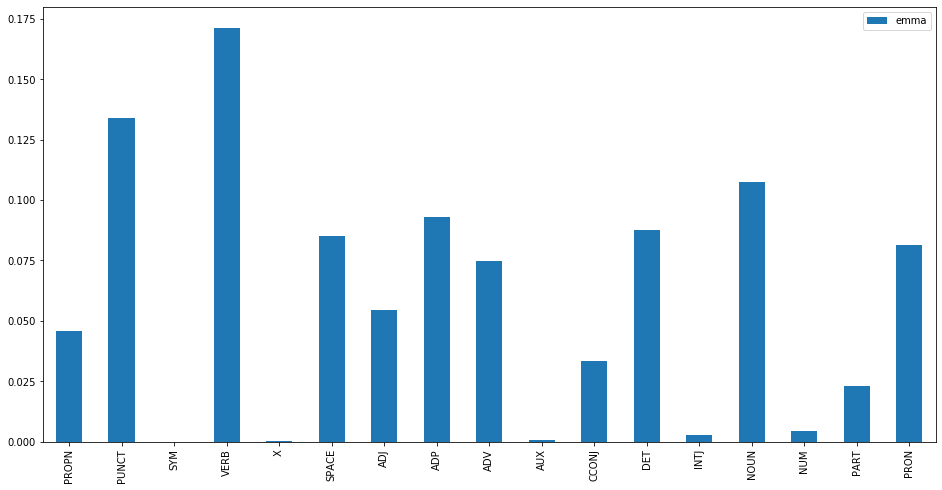

In [39]:
emmaPOS = pd.Series(emma.count_by(spacy.attrs.POS))/len(emma)

rcParams['figure.figsize'] = 16, 8
df = pd.DataFrame([emmaPOS], index=[ 'emma'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')